In [1]:
import divand
using PyPlot

# Reading data as before

In [2]:
varname = "Salinity"
filename = "WOD-Salinity-Provencal.nc"


if !isfile(filename)    
    download("https://b2drop.eudat.eu/s/UsF3RyU3xB1UM2o/download",filename)
end

value,lon,lat,depth,obstime,ids = divand.loadobs(Float64,filename,"Salinity")

CFVocab})(Any) in module Vocab at C:\Users\jmbeckers\.julia\v0.6\divand\src\Vocab.jl:22 overwritten at C:\Users\jmbeckers\.julia\v0.6\divand\src\Vocab.jl:46.


([38.2, 38.1, 38.2, 38.2, 38.3, 38.0, 38.006, 38.008, 38.012, 38.011  …  38.481, 38.481, 38.481, 38.48, 38.48, 38.48, 38.481, 38.481, 38.481, 38.481], [9.60833, 9.60833, 9.60833, 9.60833, 9.60833, 9.60833, 6.005, 6.005, 6.005, 6.005  …  8.406, 8.406, 8.406, 8.406, 8.406, 8.406, 8.406, 8.406, 8.406, 8.406], [43.2533, 43.2533, 43.2533, 43.2533, 43.2533, 43.2533, 42.572, 42.572, 42.572, 42.572  …  42.17, 42.17, 42.17, 42.17, 42.17, 42.17, 42.17, 42.17, 42.17, 42.17], [0.0, 9.92019, 19.8399, 29.7591, 49.5961, 79.348, 4.0, 5.0, 6.0, 7.0  …  1643.38, 1667.99, 1692.59, 1717.19, 1740.81, 1766.39, 1790.98, 1815.57, 1840.16, 1853.92], DateTime[1971-10-23T08:45:00.001, 1971-10-23T08:45:00.001, 1971-10-23T08:45:00.001, 1971-10-23T08:45:00.001, 1971-10-23T08:45:00.001, 1971-10-23T08:45:00.001, 1972-01-19T17:30:00.002, 1972-01-19T17:30:00.002, 1972-01-19T17:30:00.002, 1972-01-19T17:30:00.002  …  2017-10-02T06:14:02.761, 2017-10-02T06:14:02.761, 2017-10-02T06:14:02.761, 2017-10-02T06:14:02.761, 2017-

# Topography and grid definition. 

See other notebook for explanation. Here just code replicated to get topography defining the mask

In [3]:
dx = dy = 0.125/2.
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

mask,(pm,pn),(xi,yi) = divand.divand_rectdom(lonr,latr)

bathname = "gebco_30sec_4.nc"




if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download",bathname)
else
    info("Bathymetry file already downloaded")
end


bx,by,b = divand.load_bath(bathname,true,lonr,latr)



mask = falses(size(b,1),size(b,2))


    for j = 1:size(b,2)
        for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
        end
    end


INFO: Bathymetry file already downloaded


# Data selection for example

Cross validation, error calculations etc assume independant data. Hence do not take high resolution vertical profiles with all data but restrict yourself to specific small depth range. Here August data at surface:

In [4]:
sel = (depth .< 1) .& (Dates.month.(obstime) .== 8)

value = value[sel]
lon = lon[sel]
lat = lat[sel]
depth = depth[sel]
obstime = obstime[sel]
ids = ids[sel];

divand.checkobs((lon,lat,depth,obstime),value,ids)

              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (1910-08-09T00:00:00, 2014-08-28T19:36:00)
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


# Analysis

Analysis parameters have been calibrated in the other notebook example. WARNING: if the statistical parameters are incorrectly estimated, the error fields are meaningless and only provide an idea of data coverage.

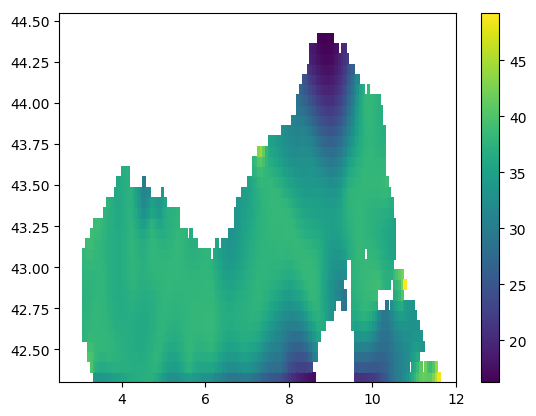

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000027DD66D8>

In [5]:
len=0.3
epsilon2=1
fi,s = divand.divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value,len,epsilon2);
pcolor(xi,yi,fi);colorbar()

## Exact error

In the 2D case you can try to calculate the exact error expression. This demands the computationally expensive evaluation of diag(s.P) accessible via the analysis returned structure s. Only available with divandrun.

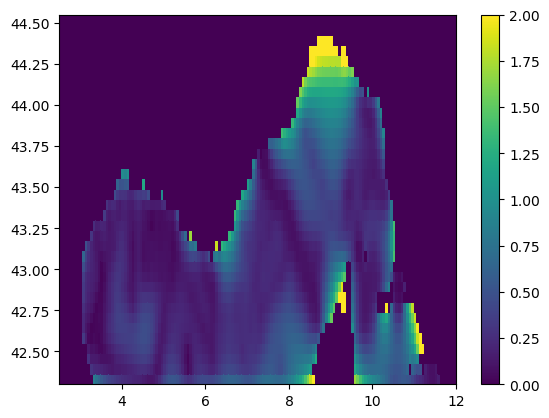

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000028132A20>

In [6]:
exerr,=divand.statevector_unpack(s.sv,diag(s.P))
pcolor(xi,yi,exerr,vmin=0, vmax=2);colorbar()

Relative error by scaling with background variance estimated using data with high errors

In [12]:
epsilon2=1E6
fib,sb = divand.divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value,len,epsilon2);
Berr,=divand.statevector_unpack(sb.sv,diag(sb.P))
pcolor(xi,yi,exerr./Berr,vmin=0, vmax=2);colorbar()

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],)

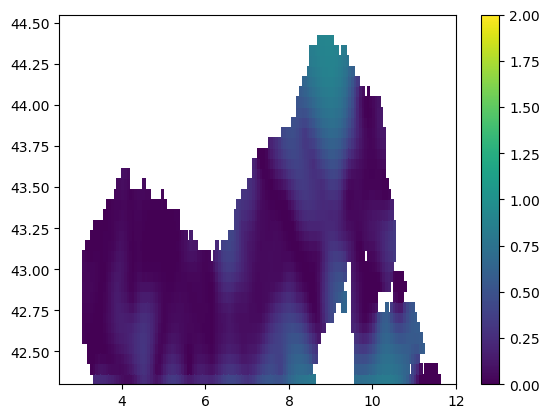

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000036A0BE80>

In [7]:
cpme=  divand.divand_cpme(mask,(pm,pn),(xi,yi),(lon,lat),value,len,epsilon2)
pcolor(xi,yi,cpme,vmin=0, vmax=2);colorbar()

typeof(Rfake) = 

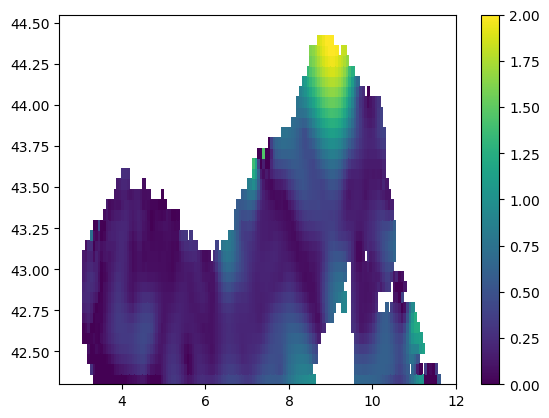

Diagonal{Float64}
issubtype(typeof(Rfake), Union{AbstractArray{Float64, 1}, AbstractArray{Float64, 2}}) = true


PyObject <matplotlib.colorbar.Colorbar object at 0x000000004398E8D0>

In [8]:
myerr,bjmb,fa,sa=  divand.divand_aexerr(mask,(pm,pn),(xi,yi),(lon,lat),value,len,epsilon2)
if myerr==0
    error("No need to approximate error, use direct calculation")
else
    pcolor(xi,yi,myerr,vmin=0, vmax=2);colorbar()
end